# File Inspection (Experimental)

**by Josh Dillon, Tyler Cox, and Aaron Parsons**, last updated August 29, 2022

In [1]:
import numpy as np
import os
import copy
import matplotlib
import matplotlib.pyplot as plt
from uvtools.plot import plot_antpos, plot_antclass
from hera_qm import ant_metrics, ant_class
from hera_cal import io, utils, redcal, apply_cal, datacontainer
from IPython.display import display, HTML
import linsolve
display(HTML("<style>.container { width:100% !important; }</style>"))
_ = np.seterr(all='ignore')  # get rid of red warnings

## Parse inputs

To use this notebook interactively, you will have to provide a sum filename path if none exists as an environment variable. All other parameters have reasonable default values.


In [2]:
# get file names
SUM_FILE = os.environ.get("SUM_FILE", None)
# SUM_FILE = '/mnt/sn1/zen.2459797.30001.sum.uvh5'  # If sum_file is not defined in the environment variables, define it here.
DIFF_FILE = SUM_FILE.replace('sum', 'diff')
PLOT = os.environ.get("PLOT", "TRUE").upper() == "TRUE"
if PLOT:
    %matplotlib inline
print(f"SUM_FILE = '{SUM_FILE}'")

SUM_FILE = '/mnt/sn1/2459822/zen.2459822.25304.sum.uvh5'


### Parse settings

In [3]:
# parse plotting settings
PLOT = os.environ.get("PLOT", True)
if PLOT:
    %matplotlib inline

# parse omnical settings
OC_MAX_DIMS = int(os.environ.get("OC_MAX_DIMS", 4))
OC_MAX_RERUN = int(os.environ.get("OC_MAX_RERUN", 4))
OC_MAXITER = int(os.environ.get("OC_MAXITER", 100))

# print settings
for setting in ['PLOT', 'OC_MAX_DIMS', 'OC_MAX_RERUN', 'OC_MAXITER']:
    print(f'{setting} = {eval(setting)}')

PLOT = True
OC_MAX_DIMS = 4
OC_MAX_RERUN = 4
OC_MAXITER = 100


### Parse Bounds

In [4]:
# ant_metrics bounds for low correlation / dead antennas
AM_CORR_BAD = float(os.environ.get("AM_CORR_BAD", 0.3))
AM_CORR_SUSPECT = float(os.environ.get("AM_CORR_SUSPECT", 0.5))
am_corr_bad = (0, AM_CORR_BAD)
am_corr_suspect = (AM_CORR_BAD, AM_CORR_SUSPECT)

# ant_metrics bounds for cross-polarized antennas
AM_XPOL_BAD = float(os.environ.get("AM_XPOL_BAD", -0.1))
AM_XPOL_SUSPECT = float(os.environ.get("AM_XPOL_SUSPECT", 0))
am_xpol_bad = (-1, AM_XPOL_BAD)
am_xpol_suspect = (AM_XPOL_BAD, AM_XPOL_SUSPECT)

# bounds on autocorrelation power
AUTO_POWER_GOOD_LOW = float(os.environ.get("AUTO_POWER_GOOD_LOW", 5))
AUTO_POWER_GOOD_HIGH = float(os.environ.get("AUTO_POWER_GOOD_HIGH", 30))
auto_power_good = (AUTO_POWER_GOOD_LOW, AUTO_POWER_GOOD_HIGH)
AUTO_POWER_SUSPECT_LOW = float(os.environ.get("AUTO_POWER_SUSPECT_LOW", 1))
AUTO_POWER_SUSPECT_HIGH = float(os.environ.get("AUTO_POWER_SUSPECT_HIGH", 80))
auto_power_suspect = (AUTO_POWER_SUSPECT_LOW, AUTO_POWER_SUSPECT_HIGH)

# bounds on autocorrelation slope
AUTO_SLOPE_GOOD_LOW = float(os.environ.get("AUTO_SLOPE_GOOD_LOW", -0.2))
AUTO_SLOPE_GOOD_HIGH = float(os.environ.get("AUTO_SLOPE_GOOD_HIGH", 0.2))
auto_slope_good = (AUTO_SLOPE_GOOD_LOW, AUTO_SLOPE_GOOD_HIGH)
AUTO_SLOPE_SUSPECT_LOW = float(os.environ.get("AUTO_SLOPE_SUSPECT_LOW", -0.4))
AUTO_SLOPE_SUSPECT_HIGH = float(os.environ.get("AUTO_SLOPE_SUSPECT_HIGH", 0.4))
auto_slope_suspect = (AUTO_SLOPE_SUSPECT_LOW, AUTO_SLOPE_SUSPECT_HIGH)

# bounds on chi^2 per antenna in omnical
OC_CSPA_GOOD = float(os.environ.get("OC_CSPA_GOOD", 3))
OC_CSPA_SUSPECT = float(os.environ.get("OC_CSPA_SUSPECT", 4))
oc_cspa_good = (0, OC_CSPA_GOOD)
oc_cspa_suspect = (OC_CSPA_GOOD, OC_CSPA_SUSPECT)

# print bounds
for bound in ['am_corr_bad', 'am_corr_suspect', 'am_xpol_bad', 'am_xpol_suspect', 
             'auto_power_good', 'auto_power_suspect', 'auto_slope_good', 'auto_slope_suspect',
             'oc_cspa_good', 'oc_cspa_suspect']:
    print(f'{bound} = {eval(bound)}')

am_corr_bad = (0, 0.2)
am_corr_suspect = (0.2, 0.4)
am_xpol_bad = (-1, -0.1)
am_xpol_suspect = (-0.1, 0.0)
auto_power_good = (5.0, 30.0)
auto_power_suspect = (1.0, 80.0)
auto_slope_good = (-0.2, 0.2)
auto_slope_suspect = (-0.4, 0.4)
oc_cspa_good = (0, 3.0)
oc_cspa_suspect = (3.0, 4.0)


## Load sum and diff data

In [5]:
hd = io.HERADataFastReader(SUM_FILE)
data, _, _ = hd.read(read_flags=False, read_nsamples=False)
hd_diff = io.HERADataFastReader(DIFF_FILE)
diff_data, _, _ = hd_diff.read(read_flags=False, read_nsamples=False)

In [6]:
ants = sorted(set([ant for bl in hd.bls for ant in utils.split_bl(bl)]))
auto_bls = [bl for bl in data if (bl[0] == bl[1]) and (utils.split_pol(bl[2])[0] == utils.split_pol(bl[2])[1])]
antpols = sorted(set([ant[1] for ant in ants]))

In [7]:
print(f'File: {SUM_FILE}')
print(f'JDs: {hd.times} ({np.median(np.diff(hd.times)) * 24 * 3600:.5f} s integrations)')
print(f'LSTS: {hd.lsts * 12 / np.pi } hours')
print(f'Frequencies: {len(hd.freqs)} {np.median(np.diff(hd.freqs)) / 1e6:.5f} MHz channels from {hd.freqs[0] / 1e6:.5f} to {hd.freqs[-1] / 1e6:.5f} MHz')
print(f'Antennas: {len(hd.data_ants)}')
print(f'Polarizations: {hd.pols}')

File: /mnt/sn1/2459822/zen.2459822.25304.sum.uvh5
JDs: [2459822.2529806  2459822.25309245] (9.66368 s integrations)
LSTS: [18.09409878 18.09679048] hours
Frequencies: 1536 0.12207 MHz channels from 46.92078 to 234.29871 MHz
Antennas: 147
Polarizations: ['nn', 'ee', 'ne', 'en']


## Find good, suspect, and bad antpols

### Run `ant_metrics`

In [8]:
am = ant_metrics.AntennaMetrics(SUM_FILE, DIFF_FILE, sum_data=data, diff_data=diff_data)
am.iterative_antenna_metrics_and_flagging(crossCut=am_xpol_bad[1], deadCut=am_corr_bad[1])

In [9]:
totally_dead_ants = [ant for ant, i in am.removal_iteration.items() if i == -1]
am_totally_dead = ant_class.AntennaClassification(good=[ant for ant in ants if ant not in totally_dead_ants], bad=totally_dead_ants)
am_corr = ant_class.antenna_bounds_checker(am.final_metrics['corr'], bad=[am_corr_bad], suspect=[am_corr_suspect], good=[(0, 1)])
am_xpol = ant_class.antenna_bounds_checker(am.final_metrics['corrXPol'], bad=[am_xpol_bad], suspect=[am_xpol_suspect], good=[(-1, 1)])
ant_metrics_class = am_totally_dead + am_corr + am_xpol
print('ant_metrics Classification:\n\n', ant_metrics_class)

ant_metrics Classification:

 Jee:
----------
good (79 antpols):
3, 4, 5, 15, 16, 17, 18, 28, 29, 30, 36, 37, 38, 45, 46, 50, 51, 52, 53, 65, 66, 67, 68, 81, 82, 83, 84, 85, 86, 87, 88, 90, 91, 98, 99, 101, 102, 105, 106, 107, 108, 116, 117, 118, 121, 122, 123, 125, 126, 137, 141, 142, 143, 144, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 180, 182, 183, 184, 185, 186, 187, 189, 190, 191, 205, 206, 207, 223, 224

suspect (0 antpols):


bad (68 antpols):
7, 8, 9, 10, 19, 20, 21, 27, 31, 32, 33, 40, 41, 42, 54, 55, 56, 57, 69, 70, 71, 72, 73, 92, 93, 94, 100, 103, 104, 109, 110, 111, 112, 119, 120, 127, 128, 129, 130, 135, 136, 138, 140, 145, 150, 155, 156, 157, 158, 160, 176, 177, 178, 179, 181, 203, 220, 221, 222, 241, 242, 243, 320, 321, 323, 324, 329, 333


Jnn:
----------
good (77 antpols):
3, 4, 5, 15, 16, 17, 18, 29, 30, 36, 37, 38, 45, 46, 50, 51, 52, 53, 65, 66, 67, 68, 73, 81, 82, 83, 84, 85, 86, 87, 88, 90, 91, 98, 99, 101, 102, 105, 106, 107, 108, 116, 117, 121, 122, 123

### Examine and classify autocorrelations

In [10]:
auto_power_class = ant_class.auto_power_checker(data, good=auto_power_good, suspect=auto_power_suspect)
auto_slope_class = ant_class.auto_slope_checker(data, good=auto_slope_good, suspect=auto_slope_suspect, edge_cut=100, filt_size=17)
auto_class = auto_power_class + auto_slope_class
print('Autocorrelation Classification:\n\n', auto_class)

Autocorrelation Classification:

 Jee:
----------
good (6 antpols):
36, 52, 70, 84, 122, 123

suspect (96 antpols):
3, 4, 5, 7, 8, 9, 10, 15, 16, 17, 18, 19, 20, 21, 28, 29, 30, 31, 37, 38, 40, 41, 42, 45, 46, 50, 51, 53, 54, 56, 65, 66, 67, 69, 71, 81, 82, 83, 85, 86, 90, 91, 94, 98, 99, 101, 102, 105, 106, 107, 108, 109, 111, 112, 116, 117, 118, 121, 125, 127, 128, 129, 130, 135, 136, 141, 143, 144, 156, 157, 158, 161, 162, 163, 164, 165, 168, 169, 176, 177, 178, 179, 180, 182, 183, 184, 185, 186, 187, 189, 191, 205, 207, 324, 329, 333

bad (45 antpols):
27, 32, 33, 55, 57, 68, 72, 73, 87, 88, 92, 93, 100, 103, 104, 110, 119, 120, 126, 137, 138, 140, 142, 145, 150, 155, 160, 166, 167, 170, 181, 190, 203, 206, 220, 221, 222, 223, 224, 241, 242, 243, 320, 321, 323


Jnn:
----------
good (25 antpols):
9, 15, 21, 30, 36, 40, 52, 53, 65, 72, 73, 84, 87, 98, 99, 101, 108, 121, 122, 123, 130, 156, 158, 165, 186

suspect (82 antpols):
3, 4, 5, 7, 8, 10, 16, 17, 18, 19, 20, 29, 31, 32, 37, 38

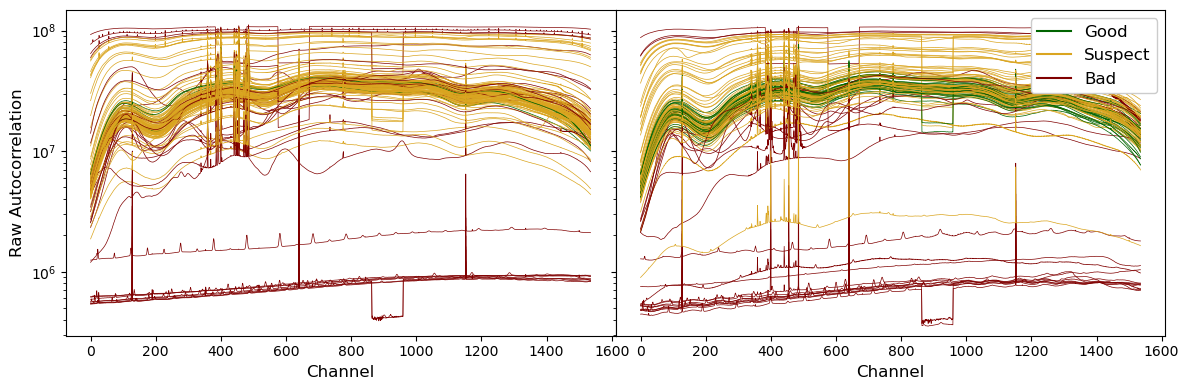

In [11]:
if PLOT:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=100, sharey=True, gridspec_kw={'wspace': 0})
    labels = []
    colors = ['darkgreen', 'goldenrod', 'maroon']
    for ax, pol in zip(axes, antpols):
        for ant in auto_class.ants:
            if ant[1] == pol:
                color = colors[auto_class.quality_classes.index(auto_class[ant])]
#                 ax.semilogy(hd.freqs / 1e6, np.mean(data[utils.join_bl(ant, ant)], axis=0), color=color, lw=.5)
                ax.semilogy(np.mean(data[utils.join_bl(ant, ant)], axis=0), color=color, lw=.5)
#         ax.set_xlabel('Frequency (MHz)', fontsize=12)
        ax.set_xlabel('Channel', fontsize=12)

    axes[0].set_ylabel('Raw Autocorrelation', fontsize=12)
    axes[1].legend([matplotlib.lines.Line2D([0], [0], color=color) for color in colors], 
                   [cls.capitalize() for cls in auto_class.quality_classes], ncol=1, fontsize=12, loc='upper right', framealpha=1)
    plt.tight_layout()

### TODO: Filter antennas based on excess RFI

In [12]:
# rfi_class = 

### Show antenna classification summary array plot

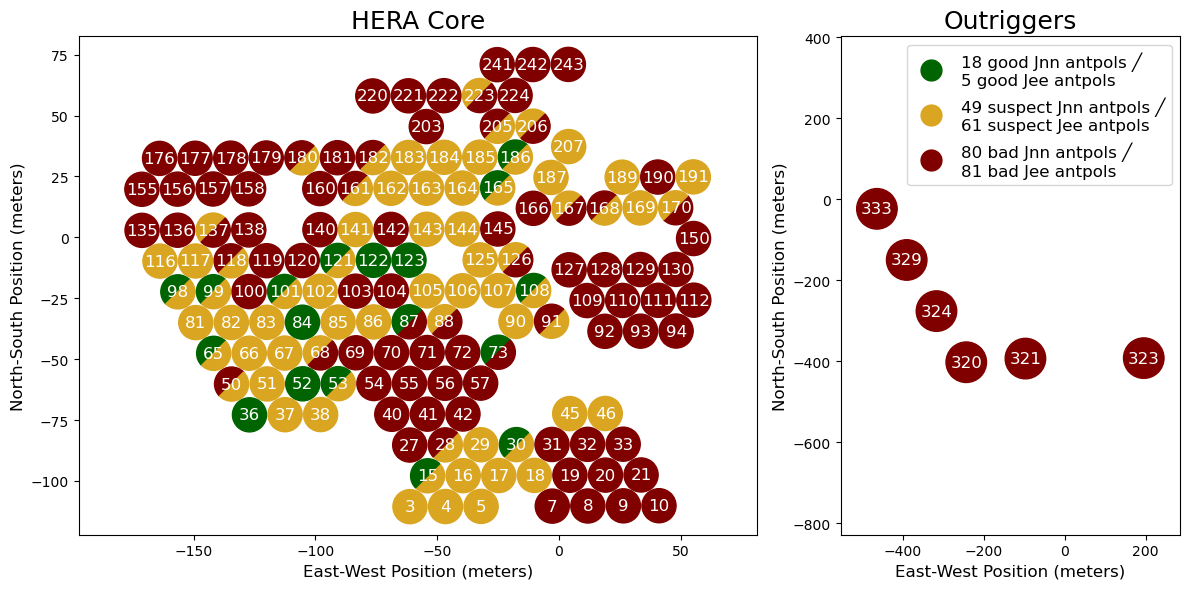

In [13]:
final_class = auto_class + ant_metrics_class #+ rfi_class
if PLOT:
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=100, gridspec_kw={'width_ratios': [2, 1]})
    plot_antclass(hd.antpos, final_class, ax=axes[0], ants=[ant for ant in hd.data_ants if ant < 320], legend=False, title='HERA Core')
    plot_antclass(hd.antpos, final_class, ax=axes[1], ants=[ant for ant in hd.data_ants if ant >= 320], radius=50, title='Outriggers')

## Redcal

TODO: 
* integrate RFI-based firstcal 
* try running both polarizations simultaneously
* try using previous solutions to refine future ones to improve speed
* simplify below code with new solutions class
* perform approximate amplitude abscal based on autocorrelations

In [14]:
rc_settings = {'fc_conv_crit': 1e-6, 'fc_maxiter': 1, 'fc_min_vis_per_ant': 10, 'max_dims': OC_MAX_DIMS,
               'oc_conv_crit': 1e-10, 'oc_maxiter': OC_MAXITER, 'check_after': OC_MAXITER, 'gain': 0.4}

def redcal_pol(pol):
    reds = redcal.get_reds(hd.data_antpos, pols=[pol], pol_mode='1pol')
    reds = sorted(redcal.filter_reds(reds, ex_ants=final_class.bad_ants, max_dims=OC_MAX_DIMS), key=len, reverse=True)
    ants_in_reds = set([ant for red in reds for bl in red for ant in utils.split_bl(bl)])
    
    on_grid = good=[ant for ant in final_class if ant in ants_in_reds and utils.join_pol(ant[1], ant[1]) == pol]
    off_grid = good=[ant for ant in final_class if ant not in ants_in_reds and utils.join_pol(ant[1], ant[1]) == pol]    
    redcal_class = ant_class.AntennaClassification(good=on_grid, bad=off_grid)
    
    cal0 = redcal.redundantly_calibrate(data, reds, **rc_settings)
    med_cspa = {ant: np.median(cal0['chisq_per_ant'][ant]) for ant in ants_in_reds}
    cspa_class = ant_class.antenna_bounds_checker(med_cspa, good=np.array(oc_cspa_good)*2, suspect=np.array(oc_cspa_suspect)*2, bad=(0, np.inf))
    redcal_class += cspa_class
    
    for i in range(OC_MAX_RERUN):    
        reds = sorted(redcal.filter_reds(reds, ex_ants=(final_class + redcal_class).bad_ants, max_dims=OC_MAX_DIMS), key=len, reverse=True)
        ants_in_reds = set([ant for red in reds for bl in red for ant in utils.split_bl(bl)])
        cal = redcal.redundantly_calibrate(data, reds, **rc_settings)
        med_cspa = {ant: np.median(cal['chisq_per_ant'][ant]) for ant in ants_in_reds}
        cspa_class = ant_class.antenna_bounds_checker(med_cspa, good=oc_cspa_good, suspect=oc_cspa_suspect, bad=(0, np.inf))    
        redcal_class += cspa_class
        if len(cspa_class.bad_ants) == 0:
            return cal, redcal_class
        
cal_ee, redcal_class_ee = redcal_pol('ee')
cal_nn, redcal_class_nn = redcal_pol('nn')
print(redcal_class_ee + redcal_class_nn)
final_class += redcal_class_ee + redcal_class_nn

Jee:
----------
good (33 antpols):
3, 5, 16, 18, 29, 30, 45, 46, 53, 83, 85, 86, 90, 91, 98, 99, 101, 102, 105, 108, 116, 117, 118, 121, 122, 164, 165, 168, 169, 184, 187, 189, 191

suspect (23 antpols):
4, 15, 17, 37, 38, 50, 65, 67, 81, 82, 84, 106, 107, 123, 125, 141, 143, 144, 183, 185, 186, 205, 207

bad (91 antpols):
7, 8, 9, 10, 19, 20, 21, 27, 28, 31, 32, 33, 36, 40, 41, 42, 51, 52, 54, 55, 56, 57, 66, 68, 69, 70, 71, 72, 73, 87, 88, 92, 93, 94, 100, 103, 104, 109, 110, 111, 112, 119, 120, 126, 127, 128, 129, 130, 135, 136, 137, 138, 140, 142, 145, 150, 155, 156, 157, 158, 160, 161, 162, 163, 166, 167, 170, 176, 177, 178, 179, 180, 181, 182, 190, 203, 206, 220, 221, 222, 223, 224, 241, 242, 243, 320, 321, 323, 324, 329, 333


Jnn:
----------
good (48 antpols):
3, 4, 5, 15, 16, 17, 18, 29, 30, 38, 45, 46, 53, 65, 73, 86, 87, 88, 90, 98, 99, 101, 102, 105, 108, 116, 117, 121, 122, 123, 125, 126, 137, 141, 143, 144, 162, 163, 164, 169, 183, 184, 185, 186, 189, 191, 206, 223

suspe

In [15]:
def expand_cal(cal, pol):
    cal2 = copy.deepcopy(cal)
    all_reds = redcal.get_reds(hd.data_antpos, pols=[pol], pol_mode='1pol')
    all_reds = sorted(redcal.filter_reds(all_reds, ex_ants=(auto_class + ant_metrics_class).bad_ants, max_dims=OC_MAX_DIMS), key=len, reverse=True)
    nsamples = datacontainer.DataContainer({bl: np.ones_like(data[bl], dtype=float) for bl in data})
    redcal.expand_omni_sol(cal2, all_reds, data, nsamples)
    return cal2
cal_ee_expanded = expand_cal(cal_ee, 'ee')
cal_nn_expanded = expand_cal(cal_nn, 'nn')

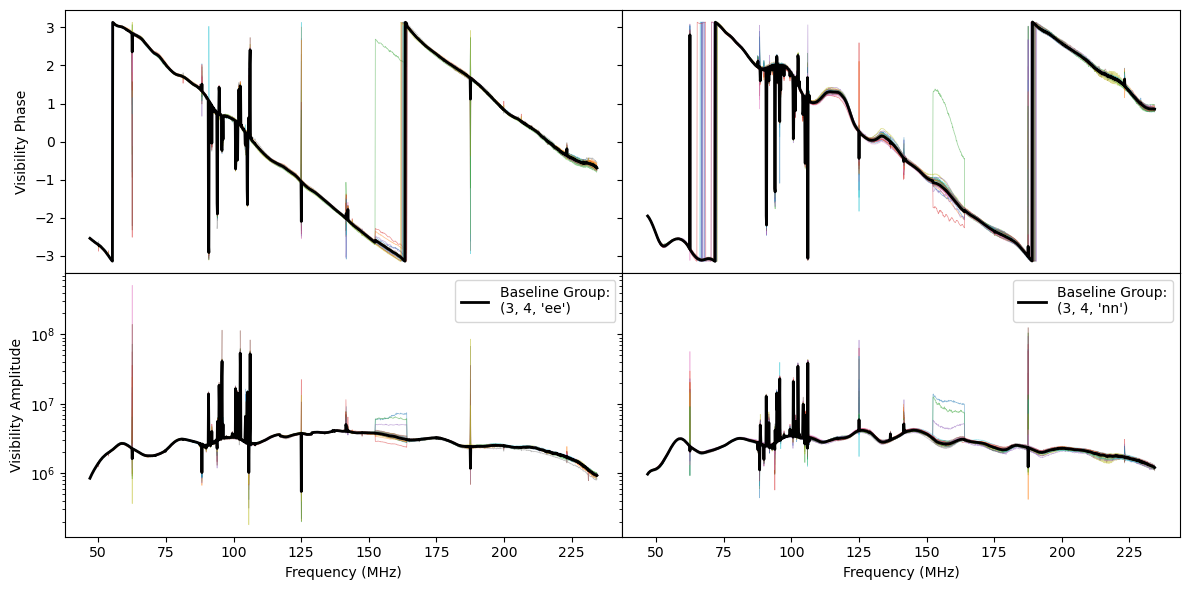

In [16]:
if PLOT:
    rc_data = copy.deepcopy(data)
    apply_cal.calibrate_in_place(rc_data, {**cal_ee['g_omnical'], **cal_nn['g_omnical']})
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 6), dpi=100, sharex='col', sharey='row', gridspec_kw={'hspace': 0, 'wspace': 0})
    for i, (pol, cal) in enumerate(zip(['ee', 'nn'], [cal_ee, cal_nn])):
        reds_here = redcal.get_reds(hd.data_antpos, pols=[pol], pol_mode='1pol')
        red = sorted(redcal.filter_reds(reds_here, ex_ants=final_class.bad_ants), key=len, reverse=True)[0]
        for bl in red:
            axes[0, i].plot(hd.freqs/1e6, np.angle(np.mean(rc_data[bl], axis=0)), alpha=.5, lw=.5)
            axes[1, i].semilogy(hd.freqs/1e6, np.abs(np.mean(rc_data[bl], axis=0)), alpha=.5, lw=.5)
        axes[0, i].plot(hd.freqs / 1e6, np.angle(np.mean(cal['v_omnical'][red[0]], axis=0)), lw=2, c='k')
        axes[1, i].semilogy(hd.freqs / 1e6, np.abs(np.mean(cal['v_omnical'][red[0]], axis=0)), lw=2, c='k', label=f'Baseline Group:\n{red[0]}')

        axes[1, i].set_xlabel('Frequency (MHz)')
        axes[1, i].legend(loc='upper right')
    axes[0, 0].set_ylabel('Visibility Phase')
    axes[1, 0].set_ylabel('Visibility Amplitude')
    plt.tight_layout()

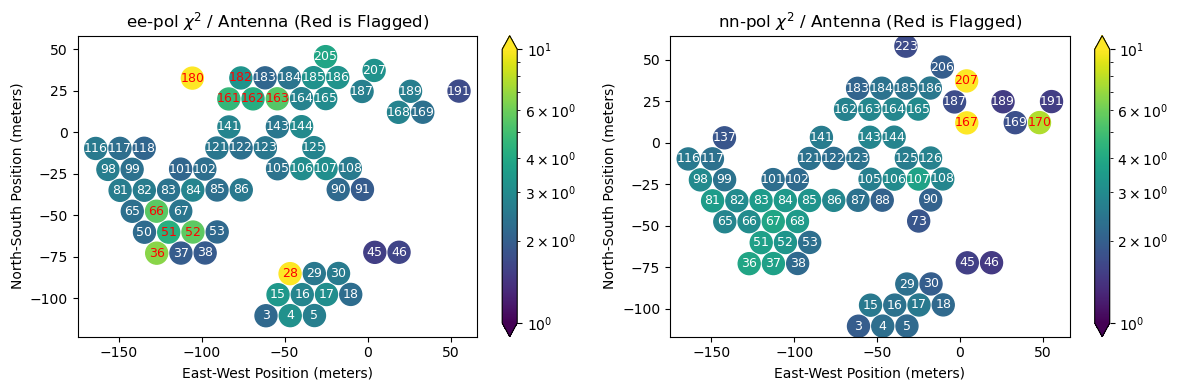

In [17]:
if PLOT:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=100)
    for ax, pol, cal in zip(axes, ['ee', 'nn'], [cal_ee_expanded, cal_nn_expanded]):
        ants = set([ant for ant in cal['chisq_per_ant']])
        cspas = [np.median(cal['chisq_per_ant'][ant]) for ant in ants]
        xpos = [hd.antpos[ant[0]][0] for ant in ants]
        ypos = [hd.antpos[ant[0]][1] for ant in ants]
        scatter = ax.scatter(xpos, ypos, s=250, c=cspas, norm=matplotlib.colors.LogNorm(vmin=1, vmax=10))
        for ant in ants:
            ax.text(hd.antpos[ant[0]][0], hd.antpos[ant[0]][1], ant[0], va='center', ha='center', fontsize=9,
                    c=('r' if ant in final_class.bad_ants else 'w'))
        plt.colorbar(scatter, ax=ax, extend='both')
        ax.axis('equal')
        ax.set_xlabel('East-West Position (meters)')
        ax.set_ylabel('North-South Position (meters)')
        ax.set_title(f'{pol}-pol $\\chi^2$ / Antenna (Red is Flagged)')
    plt.tight_layout()

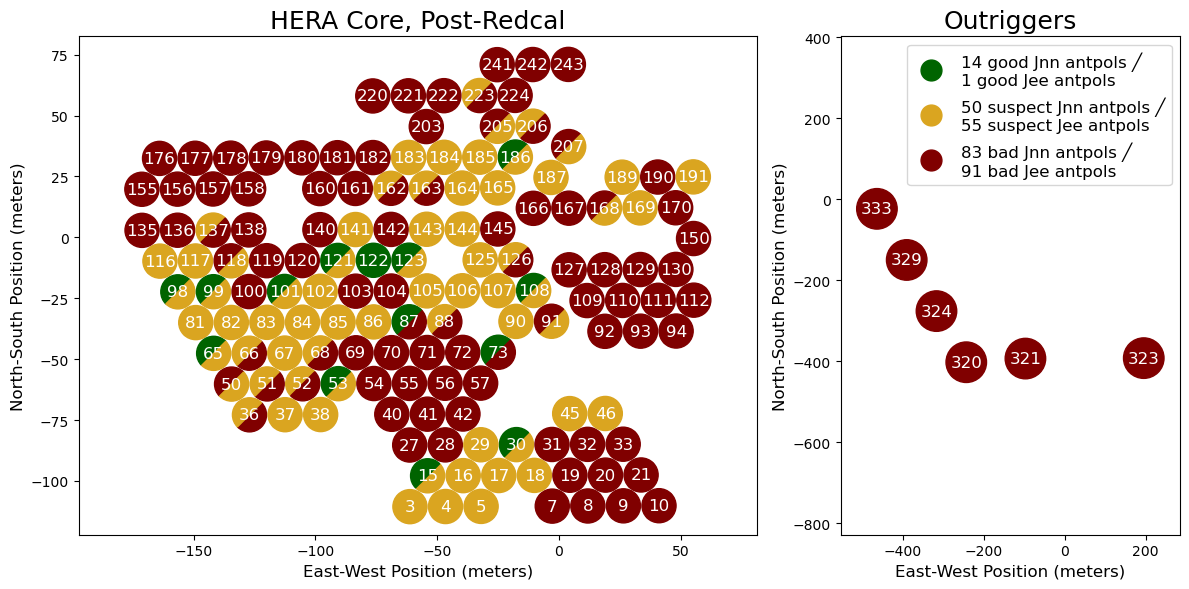

In [18]:
if PLOT:
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=100, gridspec_kw={'width_ratios': [2, 1]})
    plot_antclass(hd.antpos, final_class, ax=axes[0], ants=[ant for ant in hd.data_ants if ant < 320], legend=False, title='HERA Core, Post-Redcal')
    plot_antclass(hd.antpos, final_class, ax=axes[1], ants=[ant for ant in hd.data_ants if ant >= 320], radius=50, title='Outriggers')

## Metadata

In [19]:
from hera_cal import __version__
print('hera_cal:', __version__)
from hera_qm import __version__
print('hera_qm:', __version__)

hera_cal: 3.1.4.dev9+gea58d1b
hera_qm: 2.0.3.dev44+g7d4aa18
